<h1>Developing a Feature Space fo a Multiclass CNN Model<h1>

In [47]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.optimize import linear_sum_assignment
from keras import Model

In [48]:
# Importing user-defined modules
from Scripts.ptbxl_mc import *
from Scripts.lead2_mc import *

<h3>Loading and Pre-Processing Data:</h3>

In [49]:
npz_file = r'C:\Users\loera\OneDrive\Python Projects\College\ECG\Processed Datasets\MC_dataset.npz'

In [50]:
ptbxl_df, signals_df = load_database(npz_file)

In [51]:
# Assigning signals as the data and superclasses as the labels
X = signals_df
Y = ptbxl_df.loc[:, 'superclasses'].convert_dtypes()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [52]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17110, 5000) (17110,)
(4278, 5000) (4278,)


In [53]:
# Converting labels into binary matrix format
y_train, y_test, label_classes, label_binarizer = mc_label_encoding(y_train, y_test)

In [54]:
y_train

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

<h3>Loading Model and Extracting Features:</h3>

In [55]:
def load_model(checkpoint_path: str, model_type: str='a') -> keras.Sequential:
    '''
    Loads and returns a CNN model using pre-defined weights. The model generated and compiled is determined by the model 
    architecture specified for the 'model_type' argument.
    
    Args:
        checkpoint_path: The path containing the pre-definded weights
        model_type: The type of model architecture to compile
        
    Returns:
        keras.Sequential: The compiled model
    '''
    # Generates a model using the article architecture
    if model_type == 'a':
        model = generate_article_1D_model()
    
    # Generates a model using the default architecture
    elif model_type == 'd':
        model = generate_default_1D_model()
    
    # Loads best weights from training session
    model.load_weights(checkpoint_path)
    
    # Compiles model with similar hyperparametes as pre-trained model
    model.compile(loss = keras.losses.CategoricalCrossentropy(),
                  optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.009, beta_2=0.8, epsilon=1e-08),
                  metrics = [keras.metrics.CategoricalAccuracy(name='Accuracy'),
                             keras.metrics.Recall(name='Recall'),
                             keras.metrics.Precision(name='Precision'),
                             keras.metrics.AUC(name='AUC')])
    
    return model

In [56]:
def extract_features(checkpoint_path: str, test_data: pd.DataFrame, model_type: str='a', show_summary: bool=True) -> np.ndarray:
    '''
    Extracts feature representations of a pre-trained model using validation data. The output (final) layer is removed from the 
    model in order to return the feature embeddings from the penultimate layer.
    
    Args:
        checkpoint_path: The path containing the weights to load into the generated model
        test_data: DataFrame containing the ECG signals corresponding to the testing/validation set
        model_type: Specifies which model architecture to load
        show_summary: Boolean value that determines if the new model architecture will be displayed
        
    Returns:
        np.ndarray: A matrix containing feature embeddings from the penultimate layer
    '''
    # Loading model of specified architecture
    model = load_model(checkpoint_path=checkpoint_path, model_type=model_type)
    
    # Removing the final layer and printing architecture of the model
    model.pop()
    
    if show_summary:
        model.summary()
   
    # Predicts and extracts the features
    feature_embeddings = model.predict(test_data)
    
    return feature_embeddings

In [57]:
# Model with article architecture
checkpoint_path = r'Training Sessions\Article Multiclass\Training Session 2\CustomCNN_Lead2_36.weights.h5'

In [58]:
feature_embeddings = extract_features(checkpoint_path, x_test)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 4998, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling1D)             │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 2497, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 2497, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 2497, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling1D)             │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1246, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 1246, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 1246, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling1D)             │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 621, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 621, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 621, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max4 (MaxPooling1D)             │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 308, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 308, 512)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu5 (Activation)              │ (None, 308, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max5 (MaxPooling1D)             │ (None, 154, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop5 (Dropout)                 │ (None, 154, 512)       │             

 Total params: 8,406,976 (32.07 MB)

 Trainable params: 8,398,848 (32.04 MB)

 Non-trainable params: 8,128 (31.75 KB)

134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step


In [59]:
feature_embeddings.shape

(4278, 2048)

<h3>Generating Predictions:</h3>

In [60]:
# Loading new model with complete article architecture
model_1 = load_model(checkpoint_path)

In [61]:
y_test, y_hat = model_predict(model=model_1,
                              test_data=x_test,
                              test_labels=y_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step


In [62]:
print(f'Predictions:\n{y_hat}')
print(f'\nTrue Labels:\n{y_test}')
print(f'\nShape: {y_hat.shape}')

Predictions:
[0 3 0 ... 3 3 3]

True Labels:
[3 3 0 ... 3 3 3]

Shape: (4278,)


<h3>Computing Confusion Matrix:</h3>

In [63]:
# Utilizing the class labels extracted from the label encoding for the confusion matrix labels
matrix_labels = label_classes

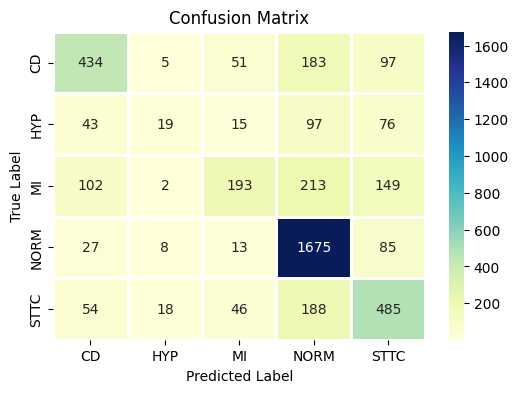

In [64]:
conf_matrix = show_confusion_matrix(y_test, y_hat, classes=matrix_labels) 

<h3>Displaying Classification Report:</h3>

In [65]:
def error_indices_report(true_labels: np.ndarray, pred_labels: np.ndarray, class_to_check: int) -> np.ndarray:
    '''
    Returns the indices where a false negative was computed for the specified class.
    
    Args:
        true_labels: The ground truth labels
        pred_labels: The predicted labels generated by a pre-trained model
        class_to_check: The class that's being checked for false negatives
    
    Returns:
        np.ndarray: An array containing the indices of all the false negatives computed for the specified class
    '''
    error_indices = np.where((true_labels == class_to_check) & (pred_labels != class_to_check))[0]
    
    return error_indices

In [66]:
# Computing the error indices for all classes
CD_error_indices = error_indices_report(y_test, y_hat, 0)
HYP_error_indices = error_indices_report(y_test, y_hat, 1)
MI_error_indices = error_indices_report (y_test, y_hat, 2)
NORM_error_indices = error_indices_report(y_test, y_hat, 3)
STTC_error_indicees = error_indices_report(y_test, y_hat, 4)

In [67]:
print('\nClassification Report:\n')
print(classification_report(y_test, y_hat, target_names=['CD', 'HYP', 'MI', 'NORM', 'STTC']))

print('False Negative CD Classifications:', len(CD_error_indices))
print('False Negative HYP Classifications:', len(HYP_error_indices))
print('False Negative MI Classifications:', len(MI_error_indices))
print('False Negative NORM Classifications:', len(NORM_error_indices))
print('False Negative STTC Classifications:', len(STTC_error_indicees))


Classification Report:

              precision    recall  f1-score   support

          CD       0.66      0.56      0.61       770
         HYP       0.37      0.08      0.13       250
          MI       0.61      0.29      0.40       659
        NORM       0.71      0.93      0.80      1808
        STTC       0.54      0.61      0.58       791

    accuracy                           0.66      4278
   macro avg       0.58      0.49      0.50      4278
weighted avg       0.63      0.66      0.62      4278

False Negative CD Classifications: 336
False Negative HYP Classifications: 231
False Negative MI Classifications: 466
False Negative NORM Classifications: 133
False Negative STTC Classifications: 306


<h3>K-Means Clustering:</h3>

In [68]:
def display_class_clusters(feature_embeddings: np.ndarray, dim_red: str='u') -> np.ndarray:
    '''
    Returns clustered superclasses from the PTB-XL database based on the feature embeddings provided. 
    Clusters are computed via K-Means clustering.
    
    Args:
        feature_embeddings: The feature embeddings to be clustered
        dim_red: The dimensionality reduction to use when visualing clusters ('p'= PCA, 't'= TSNE, 'u'= UMAP)
        
    Returns:
        np.ndarray: An array containing the assigned cluster label for each record/data point
    '''
    # Grouping extracted features into clusters and storing associated labels for all records
    kmeans = KMeans(n_clusters=5, random_state=42).fit(feature_embeddings)
    labels = kmeans.labels_
    
    # Organzing data into a DataFrame
    clusters = pd.DataFrame(data=labels, columns=['Cluster'])
    
    # Reducing data to two-dimensional feature space using the specified reduction technique
    if dim_red == 'p':
        pca = PCA(n_components=2, random_state=42)
        data = pca.fit_transform(feature_embeddings)
        col_names = ['pca1', 'pca2']
        
    elif dim_red == 't':
        tsne = TSNE(n_components=2, random_state=42)
        data = tsne.fit_transform(feature_embeddings)
        col_names = ['tsne1', 'tsne2']
    
    elif dim_red == 'u':    
        umap = UMAP(n_components=2, random_state=42)
        data = umap.fit_transform(feature_embeddings)
        col_names = ['umap1', 'umap2']

    # Storing reduced data into a DataFrame and plotting the clusters
    results = pd.DataFrame(data=data, columns=col_names) 
    sns.scatterplot(x=col_names[0],
                    y=col_names[1],
                    hue=clusters['Cluster'],
                    data=results)
    
    plt.title('K-Means Clusters')
    plt.show()
    return labels

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


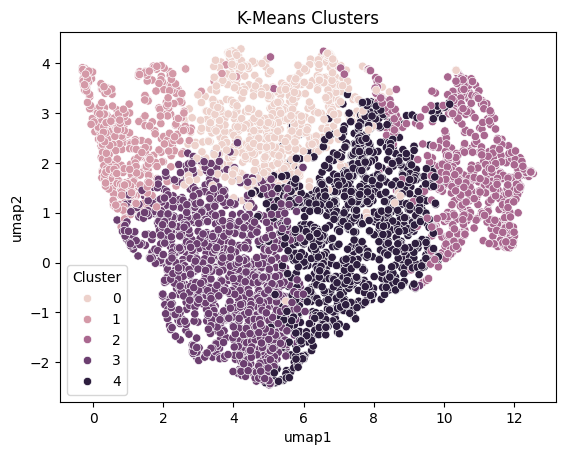

In [69]:
class_cluster_labels = display_class_clusters(feature_embeddings)

<h3>Clustering Based on Metadata:</h3>

In [70]:
def get_metadata_feature(ptbxl_database: pd.DataFrame, train_data: pd.DataFrame, test_data: pd.DataFrame, feature: str, remove_na: bool=True, min_threshold: int | None=None, max_threshold: int | None=None) -> tuple[pd.Series, pd.Series]:
    '''
    Retrieves a specific feature from the PTB-XL database and returns both training and testing labels as Pandas Series. Removes any missing 
    values by default and can additionally remove any values below or above a specified threshold.
    
    Args:
        ptbxl_database: The DataFrame containing all the PTB-XL metadata
        train_data: The ECG signals corresponding to the train dataset
        test_data: The ECG signals corresponding to the test/validation dataset
        feature: The feature/attribute within 'ptbxl_database' that is being retrieved (e.g., age, height)
        remove_na: Boolean value that determines if missing values will be removed
        min_threshold: If specified, removes any records holding a value less than the threshold
        max_threshold: If specified, removes any records holding a value larger than the threshold
        
    Returns:
        tuple: A two-element tuple (training and testing set) containing the labels for the specified feature
    '''
    # Retrieving record indices corresponding to both training and validation datasets
    train_indices = train_data.index
    test_indices = test_data.index
    
    # Acquiring labels corresponding to specified feature
    train_labels = ptbxl_database.loc[train_indices, feature].convert_dtypes()
    test_labels = ptbxl_database.loc[test_indices, feature].convert_dtypes()
    
    train_length = len(train_labels)
    test_length = len(test_labels)
    
    if remove_na:
        # Finding empty records
        na_train_labels = pd.isna(train_labels)
        na_test_labels = pd.isna(test_labels)
        
        # Keeping non-empty records
        train_labels = train_labels[~(na_train_labels)]
        test_labels = test_labels[~(na_test_labels)]
        
        print(f'Removed {train_length - len(train_labels)} records with missing values from training set')
        print(f'Removed {test_length - len(test_labels)} records with missing values from testing set')
        
        # Updating length of both datasets
        train_length = len(train_labels)
        test_length = len(test_labels)
        
    if min_threshold:
        # Removing values below minimum threshold
        train_bool_mask = (train_labels >= min_threshold)
        test_bool_mask = (test_labels >= min_threshold)
        
        train_labels = train_labels[train_bool_mask]
        test_labels = test_labels[test_bool_mask]
        
        print('\n')
        print(f'Removed {train_length - len(train_labels)} records below threshold from training set')
        print(f'Removed {test_length - len(test_labels)} records below threshold from testing set')
        
        # Updating length of both datasets
        train_length = len(train_labels)
        test_length = len(test_labels)
        
    if max_threshold:
        # Removing values above max threshold
        train_bool_mask = (train_labels <= max_threshold)
        test_bool_mask = (test_labels <= max_threshold)
        
        train_labels = train_labels[train_bool_mask]
        test_labels = test_labels[test_bool_mask]
        
        print('\n')
        print(f'Removed {train_length - len(train_labels)} records above threshold from training set')
        print(f'Removed {test_length - len(test_labels)} records above threshold from testing set')
        
        # Updating length of both datasets
        train_length = len(train_labels)
        test_length = len(test_labels)
    
    train_labels_df = pd.Series(data=train_labels, index=train_labels.index)
    test_labels_df = pd.Series(data=test_labels, index=test_labels.index)
    
    return (train_labels_df, test_labels_df)

In [71]:
# Retrieving age metadata
age_train_df, age_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'age', min_threshold=2)

Removed 0 records with missing values from training set
Removed 0 records with missing values from testing set


Removed 0 records below threshold from training set
Removed 0 records below threshold from testing set


In [72]:
# Retrieving sex metadata
sex_train_df, sex_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'sex')

Removed 0 records with missing values from training set
Removed 0 records with missing values from testing set


In [73]:
# Retrieving height metadata
height_train_df, height_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'height', min_threshold=60)

Removed 11600 records with missing values from training set
Removed 2870 records with missing values from testing set


Removed 3 records below threshold from training set
Removed 0 records below threshold from testing set


In [74]:
# Retrieving weight metadata
weight_train_df, weight_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'weight', min_threshold=5)

Removed 9588 records with missing values from training set
Removed 2434 records with missing values from testing set


Removed 0 records below threshold from training set
Removed 0 records below threshold from testing set


In [75]:
def get_metadata_buckets(train_metadata: pd.DataFrame | pd.Series, test_metadata: pd.DataFrame | pd.Series, buckets: int| list) -> tuple[pd.Series, pd.Series, np.ndarray]:
    '''
    Groups metadata into ordered buckets (i.e. categorically labeled groups).
    
    Args:
        train_metadata: The DataFrame or Series holding the labels from the training set
        test_metadata: The DataFrame or Series holding the labels from the testing/validation set        
        buckets: As an integer, creates n equally sized buckets. As a list, uses list values as the ranges for each bucket
    
    Returns:
        Tuple: A three-element tuple containing: Training buckets, testing buckets, intervals used to create buckets
    '''
    if type(buckets) == int:
        # Creating training buckets
        train_buckets_df, train_bins = pd.cut(train_metadata,
                                              bins=buckets,
                                              labels=list(range(buckets)),
                                              retbins=True)
        
        # Creating testing buckets
        test_buckets_df = pd.cut(test_metadata,
                                 bins=train_bins,
                                 labels=list(range(buckets)))
        
    elif type(buckets) == list:
        # Creating training buckets
        train_buckets_df, train_bins = pd.cut(train_metadata,
                                              bins=buckets,
                                              labels=list(range(len(buckets) - 1)),
                                              retbins=True,
                                              include_lowest=True)
        
        # Creating testing buckets
        test_buckets_df = pd.cut(test_metadata,
                                 bins=buckets,
                                 labels=list(range(len(buckets) - 1)),
                                 include_lowest=True)
    
    # Printing bucket labels and their intervals
    print(f'Bucket Intervals:\n')
    for i in range((len(train_bins) - 1)):
        if i == 0:
            print(f'Bucket {i}: [{train_bins[i]}, {train_bins[i+1]}]')
        else:
            print(f'Bucket {i}: ({train_bins[i]}, {train_bins[i+1]}]')
                
    return (train_buckets_df, test_buckets_df, train_bins)

In [76]:
age_buckets = [2, 25, 50, 75, np.inf]
age_train_labels, age_test_labels, age_bucket_intervals = get_metadata_buckets(age_train_df, age_test_df, buckets=age_buckets)

Bucket Intervals:

Bucket 0: [2.0, 25.0]
Bucket 1: (25.0, 50.0]
Bucket 2: (50.0, 75.0]
Bucket 3: (75.0, inf]


In [77]:
height_buckets = [60, 100, 133, 166, np.inf]
height_train_labels, height_test_labels, height_bucket_intervals = get_metadata_buckets(height_train_df, height_test_df, buckets=height_buckets)

Bucket Intervals:

Bucket 0: [60.0, 100.0]
Bucket 1: (100.0, 133.0]
Bucket 2: (133.0, 166.0]
Bucket 3: (166.0, inf]


In [78]:
weight_buckets = [5, 60, 120, 180, np.inf]
weight_train_labels, weight_test_labels, weight_bucket_intervals = get_metadata_buckets(weight_train_df, weight_test_df, buckets=weight_buckets)

Bucket Intervals:

Bucket 0: [5.0, 60.0]
Bucket 1: (60.0, 120.0]
Bucket 2: (120.0, 180.0]
Bucket 3: (180.0, inf]


In [79]:
# Creating feature embeddings specific to each metadata feature
age_test_indices = age_test_df.index
age_feature_embeddings = extract_features(checkpoint_path, x_test.loc[age_test_indices], show_summary=False)

sex_test_indices = sex_test_df.index
sex_feature_embeddings = extract_features(checkpoint_path, x_test.loc[sex_test_indices], show_summary=False)

height_test_indices = height_test_df.index
height_feature_embeddings = extract_features(checkpoint_path, x_test.loc[height_test_indices], show_summary=False)

weight_test_indices = weight_test_df.index
weight_feature_embeddings = extract_features(checkpoint_path, x_test.loc[weight_test_indices], show_summary=False)

134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step


In [80]:
def display_metadata_clusters(metadata: pd.Series, feature_embeddings: np.ndarray, bucket_intervals: np.ndarray | None=None, dim_red: str='u'):
    '''
    Clusters feature embeddings via K-Means using the number of buckets/groups found in the data. The provided metadata should be
    labeled according to its bucket group and consist of one of the features found within the PTB-XL database.
    
    Args:
        metadata: The metadata (e.g., age, height) that will be used to cross-check the clustered feature embeddings
        feature_embeddings: The feature embeddings that will be clustered
        bucket_intervals: An array containing the ranges of all buckets regarding the metadata
        dim_red: The dimensionality reduction to use when visualing clusters ('p'= PCA, 't'= TSNE, 'u'= UMAP)
        
    Returns:
        np.ndarray: An array containing the assigned cluster labels for each record/data point
    '''
    # Retrieving the number of clusters
    try:
        n_clusters = len(bucket_intervals) - 1
    except TypeError:
        n_clusters = 2
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(feature_embeddings)
    cluster_labels = kmeans.labels_
    
    # Reducing feature embeddings to a two-dimensional feature space using the specified reduction technique
    if dim_red == 'p':
        pca = PCA(n_components=2, random_state=42)
        data = pca.fit_transform(feature_embeddings)
        col_names = ['pca1', 'pca2']
        
    elif dim_red == 't':
        tsne = TSNE(n_components=2, random_state=42)
        data = tsne.fit_transform(feature_embeddings)
        col_names = ['tsne1', 'tsne2']
    
    elif dim_red == 'u':    
        umap = UMAP(n_components=2, random_state=42)
        data = umap.fit_transform(feature_embeddings)
        col_names = ['umap1', 'umap2']
    
    # Storing transformed data into a DataFrame and plotting the clusters
    column_name = metadata.name.capitalize()
   
    results = pd.DataFrame(data=data, columns=col_names)
    results[f'{column_name} Group'] = metadata.reset_index(drop=True)
    results['Cluster'] = cluster_labels
    
    sns.scatterplot(x=col_names[0],
                    y=col_names[1],
                    hue=results['Cluster'],
                    style=results[f'{column_name} Group'],
                    data=results)
    plt.title(f'K-Means Clusters vs. {column_name}')
    plt.show()
    
    return cluster_labels

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


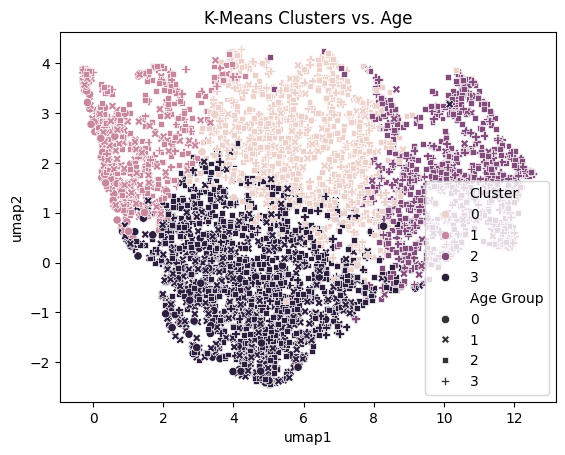

In [81]:
age_cluster_labels = display_metadata_clusters(age_test_labels, age_feature_embeddings, age_bucket_intervals)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


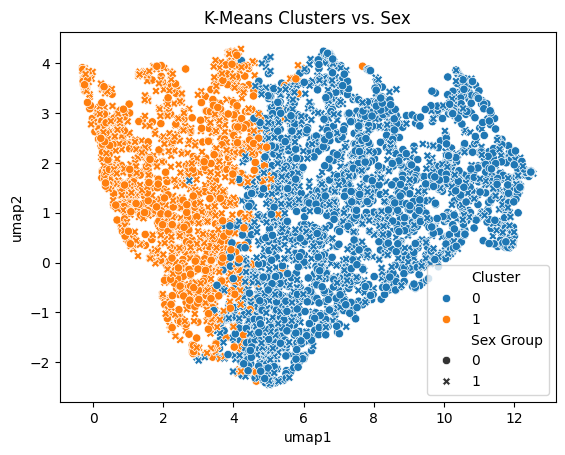

In [82]:
sex_cluster_labels = display_metadata_clusters(sex_test_df, sex_feature_embeddings)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


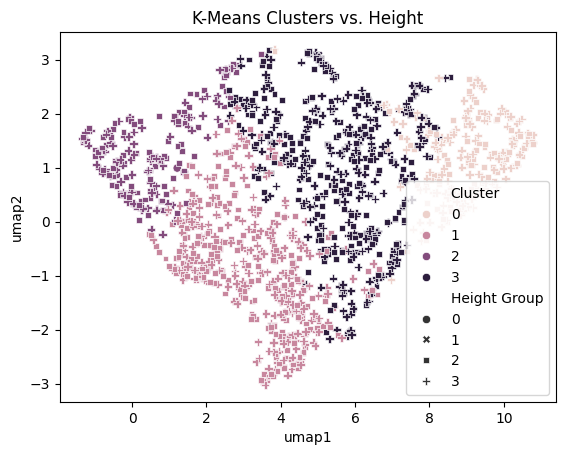

In [83]:
height_cluster_labels = display_metadata_clusters(height_test_labels, height_feature_embeddings, height_bucket_intervals)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


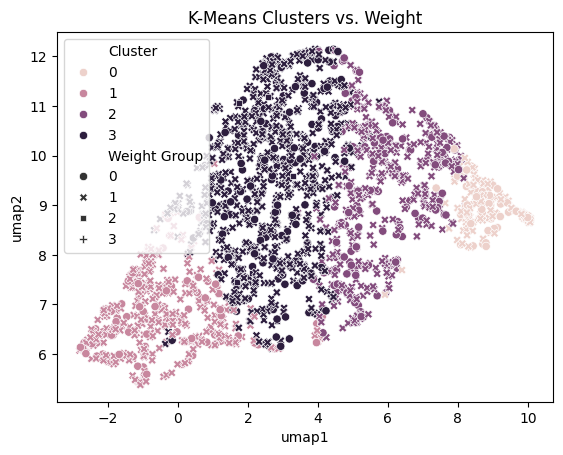

In [84]:
weight_cluster_labels = display_metadata_clusters(weight_test_labels, weight_feature_embeddings, weight_bucket_intervals)

<h3>Evaluating Clustering Accuracy:</h3>

In [85]:
def get_cluster_accuracy(test_labels: pd.DataFrame | pd.Series, cluster_labels: np.ndarray) -> float:
    '''
    Determines the accuracy between the ground truth labels and the assigned cluster labels using linear sum assignment.
    The best cluster-class pair are computed and stored in a dictionary with the following format: {cluster_label : class_label}.
    This dictionary mapping is then used to return the accuracy score.
    
    Args:
        test_labels: The ground truth labels corresponding to the testing/validation set
        cluster_labels: The labels generated from clustering the data points within the testing set
        
    Returns:
        float: A float value reflecting the accuracy between the ground truth labels and cluster labels
    '''
    # Computing the confusion matrix
    conf_matrix = confusion_matrix(test_labels, cluster_labels, labels=np.unique(test_labels))
    print((f'Confusion Matrix:\n{conf_matrix}'))
    
    # Maximizing number of correct matches between a particular cluster and class 
    row_idx, col_idx = linear_sum_assignment(conf_matrix, maximize=True)
    label_mapping = {cluster: label for cluster, label in zip(col_idx, row_idx)}
    print(f'\nLabel Mapping:\n{label_mapping}')
    
    # Mapping clusters to labels (handles missing clusters)
    mapped_pred = [label_mapping.get(cluster, -1) for cluster in cluster_labels]
    mapped_pred = np.asarray(mapped_pred)
    
    # Computing accuracy (Ignoring -1s if necessary)
    mask = np.array(mapped_pred) != -1
    accuracy = accuracy_score(np.array(test_labels[mask]), np.array(mapped_pred[mask]))
    
    print(f'\nClustering Accuracy: {accuracy:.2%}')
    return accuracy

In [86]:
# Determining clustering accuracy for superclass labels
class_cluster_accuracy = get_cluster_accuracy(y_test, class_cluster_labels) 

Confusion Matrix:
[[  63   24  364   80  239]
 [  59   26   39   56   70]
 [  92   22  187  102  256]
 [  96  343    3 1001  365]
 [ 366   71   80   57  217]]

Label Mapping:
{2: 0, 1: 1, 4: 2, 3: 3, 0: 4}

Clustering Accuracy: 47.05%


In [87]:
# Determining clustering accuracy for age metadata
age_cluster_accuracy = get_cluster_accuracy(age_test_labels, age_cluster_labels)

Confusion Matrix:
[[  7  65   4  99]
 [131 180  58 515]
 [656 282 604 872]
 [265  70 301 169]]

Label Mapping:
{1: 0, 3: 1, 0: 2, 2: 3}

Clustering Accuracy: 35.93%


In [88]:
# Determining clustering accuracy for sex metadata
sex_cluster_accuracy = get_cluster_accuracy(sex_test_df, sex_cluster_labels)

Confusion Matrix:
[[1613  636]
 [1174  855]]

Label Mapping:
{0: 0, 1: 1}

Clustering Accuracy: 57.69%


In [89]:
# Determining clustering accuracy for height metadata
height_cluster_accuracy = get_cluster_accuracy(height_test_labels, height_cluster_labels)

Confusion Matrix:
[[  0   0   1   0]
 [  1   0   0   1]
 [ 98 238 114 234]
 [154 235  92 240]]

Label Mapping:
{2: 0, 0: 1, 1: 2, 3: 3}

Clustering Accuracy: 34.09%


In [90]:
# Determining clustering accuracy for height metadata
weight_cluster_accuracy = get_cluster_accuracy(weight_test_labels, weight_cluster_labels)

Confusion Matrix:
[[ 51 104 136 164]
 [ 98 299 319 663]
 [  0   2   0   7]
 [  1   0   0   0]]

Label Mapping:
{2: 0, 3: 1, 1: 2, 0: 3}

Clustering Accuracy: 43.49%


<h3>Implementing a Probing Classifier:</h3>

In [ ]:
def generate_probing_classifier(model: keras.Sequential, train_data: pd.DataFrame, test_data: pd.DataFrame, n_classes: int, layer_to_probe: str | int=-2) -> tuple[keras.Sequential, np.ndarray, np.ndarray]:
    '''
    Generates a probing classifier based off the model provided. Training and testing features are created by utilizing an intermediate
    model to generate predictions. These features are then returned and can then be used to train/fit the compiled classifier.
    
    Args:
        model: The pre-trained model that will be analyzed
        train_data: The training data used for the original model
        test_data: The testing/validation data used for the original model
        n_classes: The number of unique classes/labels
        layer_to_probe: The layer from the original model to probe (defaults to the penultimate layer)
    
    Returns:
        tuple: A three-element tuple containing the compiled probing classifier, its training features, and its testing features
    '''
    # Defining the input and ouput layer for a smaller, intermediate model
    input_layer = model.layers[0].input
    
    if isinstance(layer_to_probe, str):
        output_layer = model.get_layer(layer_to_probe).output
    else:
        output_layer = model.get_layer(index=layer_to_probe).output
        
    # Building the intermediate model
    intermediate_model = Model(inputs=input_layer, outputs=output_layer)
    
    # Retrieving the feature embeddings for both training and validations sets
    train_features = intermediate_model.predict(train_data)
    test_features = intermediate_model.predict(test_data)
    
    if n_classes == 2:
        # Defining the probe classifier's architecture
        probe_classifier = Sequential([Input(shape=(train_features.shape[1],)),
                                    Dense(1, activation='sigmoid')])
        
        # Compiling the classifier
        probe_classifier.compile(loss = keras.losses.BinaryCrossentropy(),
                                optimizer = keras.optimizers.Adam(learning_rate=0.001),
                                metrics = [keras.metrics.BinaryAccuracy(name='Accuracy')])
        
    elif n_classes > 2:
        # Defining the probe classifier's architecture
        probe_classifier = Sequential([Input(shape=(train_features.shape[1],)),
                                    Dense(n_classes, activation='softmax')])
        
        # Compiling the classifier
        probe_classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
                                optimizer = keras.optimizers.Adam(learning_rate=0.001),
                                metrics = [keras.metrics.SparseCategoricalAccuracy(name='Accuracy')])
    
    return (probe_classifier, train_features, test_features)

In [111]:
len(age_bucket_intervals) - 1

4

In [92]:
# Generating probing classifier specific to each and its training/testing features
age_compiled_classifier, age_train_features, age_test_features = generate_probing_classifier(model_1,
                                                                                             x_train.loc[age_train_labels.index],
                                                                                             x_test.loc[age_test_labels.index],
                                                                                             n_classes=len(age_bucket_intervals) - 1)

535/535 ━━━━━━━━━━━━━━━━━━━━ 94s 174ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step


In [93]:
sex_compiled_classifier, sex_train_features, sex_test_features = generate_probing_classifier(model_1,
                                                                                              x_train.loc[sex_train_df.index],
                                                                                              x_test.loc[sex_test_df.index],
                                                                                              n_classes=2)

535/535 ━━━━━━━━━━━━━━━━━━━━ 99s 184ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step


In [94]:
height_compiled_classifier, height_train_features, height_test_features = generate_probing_classifier(model_1,
                                                                                                      x_train.loc[height_train_labels.index],
                                                                                                      x_test.loc[height_test_labels.index],
                                                                                                      n_classes=len(height_bucket_intervals) - 1)

173/173 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step


In [95]:
weight_compiled_classifier, weight_train_features, weight_test_features = generate_probing_classifier(model_1,
                                                                                                      x_train.loc[weight_train_labels.index],
                                                                                                      x_test.loc[weight_test_labels.index],
                                                                                                      n_classes=len(weight_bucket_intervals) - 1)

236/236 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step


In [96]:
def train_probe_classifier(probe_model: keras.Sequential, train_features: np.ndarray, train_labels: np.ndarray, test_features: np.ndarray, test_labels: np.ndarray, save_path: str, epochs: int=50) -> tuple:
    '''
    Trains a compiled classifier based on the training and testing features provided.
    
    Args:
        probe_model: A compiled probing classifier
        train_features: Feature embeddings to be used for training
        train_labels: Labels corresponding the training set
        test_features: Feature embeddings to be used for testing/validation
        test_labels: Labels corresponding to the testing set
        save_path: Location to save the probing classifier's best weights
        epochs: The number of epochs to train the classifier for
        
    Returns:
        tuple: A two-element tuple containing the training history of the classifier and the trained classifier itself
    '''
    # Defining checkpoint parameters
    probe_callbacks = [keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                       monitor='val_Accuracy',
                                                       verbose=1,
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       mode='max')]
    
    # Ensuring training and testing labels are in readable format
    train_labels = train_labels.astype('int32')
    test_labels = test_labels.astype('int32')
    
    # Training the classifier
    history = probe_model.fit(train_features,
                              train_labels,
                              epochs=epochs,
                              validation_data=(test_features, test_labels),
                              callbacks=probe_callbacks)
    
    return (history, probe_model)

In [97]:
# Defining save path
save_path = r'Probe Classifier\Multiclass\Age\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on age metadata
age_history, age_trained_classifier = train_probe_classifier(probe_model=age_compiled_classifier,
                                                             train_features=age_train_features,
                                                             train_labels=age_train_labels,
                                                             test_features=age_test_features,
                                                             test_labels=age_test_labels,
                                                             save_path=save_path)

Epoch 1/50
493/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5451 - loss: 1.0347
Epoch 1: val_Accuracy improved from -inf to 0.60005, saving model to Probe Classifier\Multiclass\Age\50_epochs\Weights\Probe_Classifier_1.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.5469 - loss: 1.0303 - val_Accuracy: 0.6000 - val_loss: 0.9116
Epoch 2/50
489/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5897 - loss: 0.9323
Epoch 2: val_Accuracy improved from 0.60005 to 0.60566, saving model to Probe Classifier\Multiclass\Age\50_epochs\Weights\Probe_Classifier_2.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Accuracy: 0.5891 - loss: 0.9331 - val_Accuracy: 0.6057 - val_loss: 0.9000
Epoch 3/50
528/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5798 - loss: 0.9377
Epoch 3: val_Accuracy improved from 0.60566 to 0.61033, saving model to Probe Classifier\Multiclass\Age\50_epochs\Weights\Probe_Classifier_3.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Accuracy: 0.

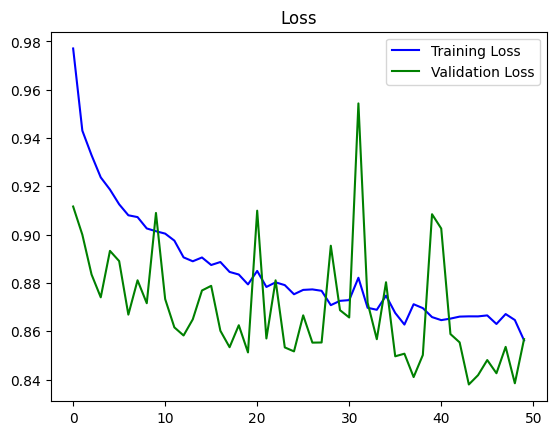

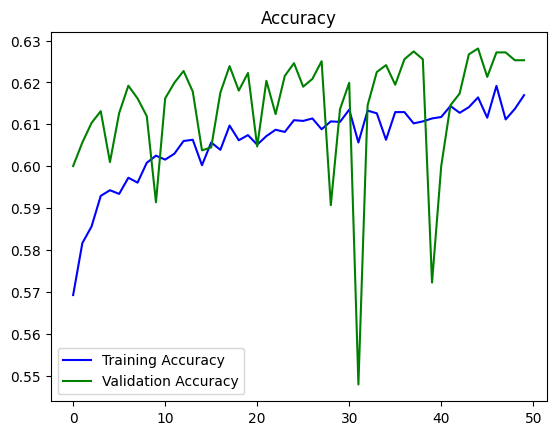

KeyError: 'AUC'

In [99]:
# Plotting age training history
plot_graphs(age_history)

In [100]:
# Defining save path
save_path = r'Probe Classifier\Multiclass\Sex\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on sex metadata
sex_history, sex_trained_classifier = train_probe_classifier(probe_model=sex_compiled_classifier,
                                                             train_features=sex_train_features,
                                                             train_labels=sex_train_df,
                                                             test_features=sex_test_features,
                                                             test_labels=sex_test_df,
                                                             save_path=save_path)

Epoch 1/50
511/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6469 - Accuracy: 0.6099 - loss: 0.6585
Epoch 1: val_Accuracy improved from -inf to 0.65591, saving model to Probe Classifier\Multiclass\Sex\50_epochs\Weights\Probe_Classifier_1.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.6482 - Accuracy: 0.6109 - loss: 0.6579 - val_AUC: 0.7089 - val_Accuracy: 0.6559 - val_loss: 0.6248
Epoch 2/50
508/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7070 - Accuracy: 0.6518 - loss: 0.6254
Epoch 2: val_Accuracy improved from 0.65591 to 0.66690, saving model to Probe Classifier\Multiclass\Sex\50_epochs\Weights\Probe_Classifier_2.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7070 - Accuracy: 0.6519 - loss: 0.6254 - val_AUC: 0.7187 - val_Accuracy: 0.6669 - val_loss: 0.6171
Epoch 3/50
534/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7226 - Accuracy: 0.6660 - loss: 0.6151
Epoch 3: val_Accuracy improved from 0.66690 to 0.66994, saving model to Probe Classifier\Multiclass\S

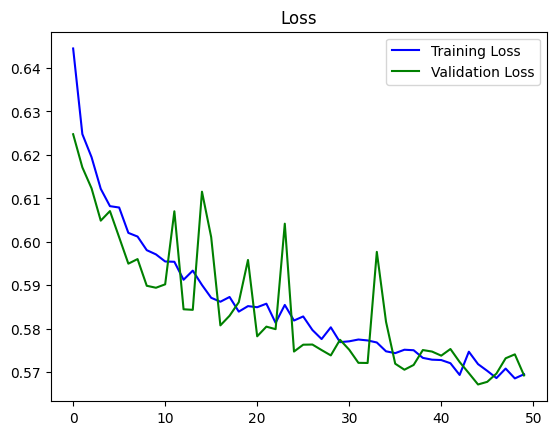

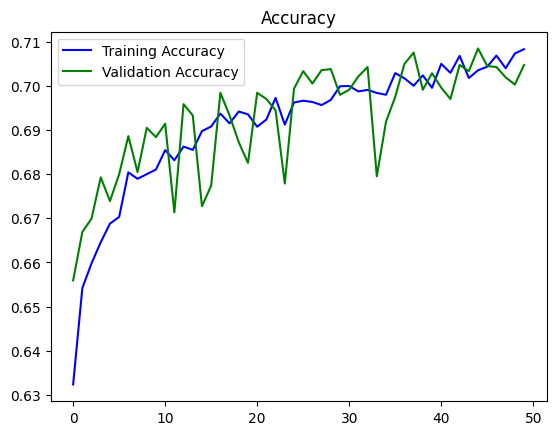

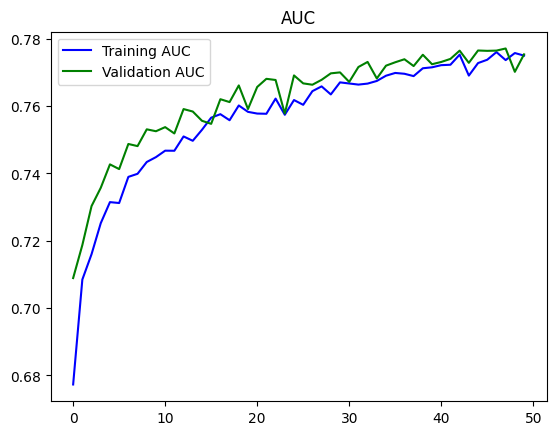

In [101]:
# Plotting sex training history
plot_graphs(sex_history)

In [102]:
# Defining save path
save_path = r'Probe Classifier\Multiclass\Height\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on height metadata
height_history, height_trained_classifier = train_probe_classifier(probe_model=height_compiled_classifier,
                                                                   train_features=height_train_features,
                                                                   train_labels=height_train_labels,
                                                                   test_features=height_test_features,
                                                                   test_labels=height_test_labels,
                                                                   save_path=save_path)

Epoch 1/50
148/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5010 - loss: 0.7970   
Epoch 1: val_Accuracy improved from -inf to 0.58523, saving model to Probe Classifier\Multiclass\Height\50_epochs\Weights\Probe_Classifier_1.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.5070 - loss: 0.7868 - val_Accuracy: 0.5852 - val_loss: 0.6906
Epoch 2/50
130/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5767 - loss: 0.6926
Epoch 2: val_Accuracy improved from 0.58523 to 0.60298, saving model to Probe Classifier\Multiclass\Height\50_epochs\Weights\Probe_Classifier_2.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.5766 - loss: 0.6940 - val_Accuracy: 0.6030 - val_loss: 0.6749
Epoch 3/50
133/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5821 - loss: 0.6867
Epoch 3: val_Accuracy improved from 0.60298 to 0.61719, saving model to Probe Classifier\Multiclass\Height\50_epochs\Weights\Probe_Classifier_3.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

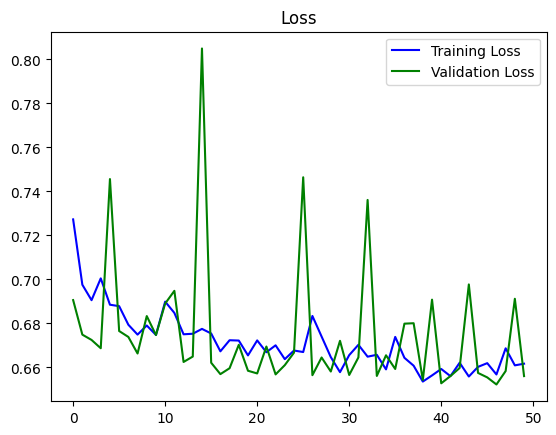

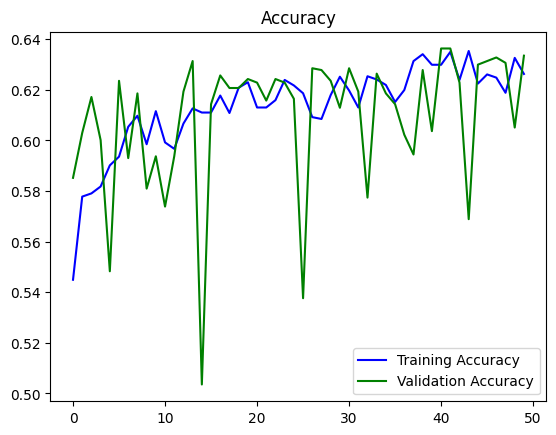

KeyError: 'AUC'

In [103]:
# Plotting height training history
plot_graphs(height_history)

In [104]:
# Defining save path
save_path = r'Probe Classifier\Multiclass\Weight\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on weight metadata
weight_history, weight_trained_classifier = train_probe_classifier(probe_model=weight_compiled_classifier,
                                                                   train_features=weight_train_features,
                                                                   train_labels=weight_train_labels,
                                                                   test_features=weight_test_features,
                                                                   test_labels=weight_test_labels,
                                                                   save_path=save_path)

Epoch 1/50
231/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.6926 - loss: 0.6856
Epoch 1: val_Accuracy improved from -inf to 0.69848, saving model to Probe Classifier\Multiclass\Weight\50_epochs\Weights\Probe_Classifier_1.weights.h5
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.6931 - loss: 0.6844 - val_Accuracy: 0.6985 - val_loss: 0.6247
Epoch 2/50
215/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.6818 - loss: 0.6564
Epoch 2: val_Accuracy improved from 0.69848 to 0.74512, saving model to Probe Classifier\Multiclass\Weight\50_epochs\Weights\Probe_Classifier_2.weights.h5
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.6845 - loss: 0.6530 - val_Accuracy: 0.7451 - val_loss: 0.5621
Epoch 3/50
200/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.7332 - loss: 0.5834
Epoch 3: val_Accuracy improved from 0.74512 to 0.75000, saving model to Probe Classifier\Multiclass\Weight\50_epochs\Weights\Probe_Classifier_3.weights.h5
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Acc

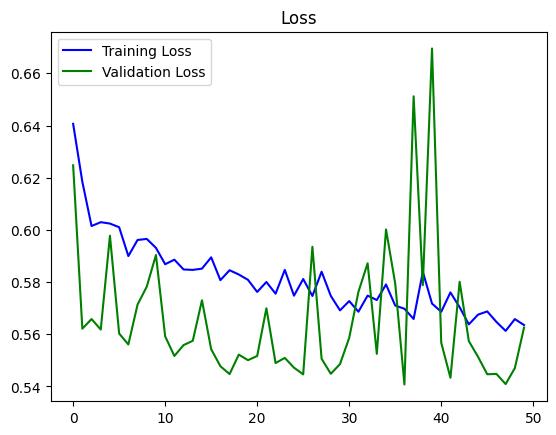

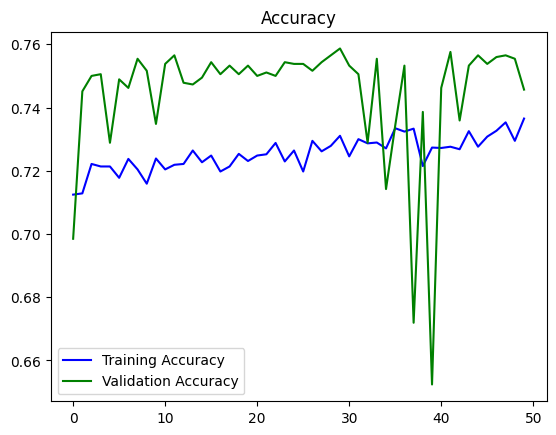

KeyError: 'AUC'

In [105]:
# Plotting weight training history
plot_graphs(weight_history)

In [106]:
def get_probe_score(probe_model: keras.Sequential, test_features: np.ndarray, test_labels: np.ndarray) -> list:
    '''
    Returns the loss and accuracy scores of a trained probing classifier.
    
    Args:
        probe_model: The pre-trained probing classifier
        test_features: The feature embeddings used for testing/validation
        test_labels: The labels corresponding the test features
        
    Returns:
        list: A two-element list containing the loss and accuracy of the probing classifier
    '''
    # Ensuring testing labels are in readable format
    test_labels = test_labels.astype('int32')
    
    score = evaluate_model(probe_model, test_features, test_labels)
    return score

In [107]:
age_score = get_probe_score(age_trained_classifier, age_test_features, age_test_labels)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.6175 - loss: 0.8619

Loss on test data: 85.67%

Accuracy on test data: 62.53%


In [108]:
sex_score = get_probe_score(sex_trained_classifier, sex_test_features, sex_test_df)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7852 - Accuracy: 0.7172 - loss: 0.5623

Loss on test data: 56.93%

Accuracy on test data: 70.48%


In [109]:
height_score = get_probe_score(height_trained_classifier, height_test_features, height_test_labels)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.6477 - loss: 0.6450 

Loss on test data: 65.60%

Accuracy on test data: 63.35%


In [110]:
weight_score = get_probe_score(weight_trained_classifier, weight_test_features, weight_test_labels)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.7527 - loss: 0.5549

Loss on test data: 56.26%

Accuracy on test data: 74.57%


<h3>Evaluating Accuracy of Probing Classifier:</h3>

In [114]:
# Loading the best weights for each feature-specific classifier
age_compiled_classifier.load_weights(r'Probe Classifier\Multiclass\Age\50_epochs\Weights\Probe_Classifier_45.weights.h5')

sex_compiled_classifier.load_weights(r'Probe Classifier\Multiclass\Sex\50_epochs\Weights\Probe_Classifier_45.weights.h5')

height_compiled_classifier.load_weights(r'Probe Classifier\Multiclass\Height\50_epochs\Weights\Probe_Classifier_41.weights.h5')

weight_compiled_classifier.load_weights(r'Probe Classifier\Multiclass\Weight\50_epochs\Weights\Probe_Classifier_30.weights.h5')

In [115]:
# Generating predictions for age groups
age_probe_pred = age_compiled_classifier.predict(age_test_features)
age_probe_pred = np.argmax(age_probe_pred, axis=1)

print(age_probe_pred)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[1 2 2 ... 2 1 2]


In [116]:
age_acc = accuracy_score(age_test_labels, age_probe_pred)
print(f'Age Accuracy Score: {age_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(age_test_labels, age_probe_pred))

Age Accuracy Score: 62.81%

Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.38      0.45       175
           1       0.55      0.38      0.45       884
           2       0.66      0.83      0.74      2414
           3       0.54      0.36      0.43       805

    accuracy                           0.63      4278
   macro avg       0.58      0.49      0.52      4278
weighted avg       0.61      0.63      0.61      4278



In [117]:
# Generating predictions for sex groups
sex_probe_pred = sex_compiled_classifier.predict(sex_test_features)
sex_probe_pred = (sex_probe_pred >= 0.5).astype(int).flatten()

print(sex_probe_pred)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[1 0 0 ... 0 0 1]


In [118]:
sex_acc = accuracy_score(sex_test_df, sex_probe_pred)
print(f'Sex Accuracy Score: {sex_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(sex_test_df, sex_probe_pred, target_names=['Male', 'Female']))

Sex Accuracy Score: 70.85%

Classification Report:

               precision    recall  f1-score   support

        Male       0.71      0.74      0.73      2249
      Female       0.70      0.67      0.69      2029

    accuracy                           0.71      4278
   macro avg       0.71      0.71      0.71      4278
weighted avg       0.71      0.71      0.71      4278



In [119]:
# Generating predictions for height groups
height_probe_pred = height_compiled_classifier.predict(height_test_features)
height_probe_pred = np.argmax(height_probe_pred, axis=1)

print(height_probe_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[2 3 3 ... 3 2 3]


In [120]:
height_acc = accuracy_score(height_test_labels, height_probe_pred)
print(f'Height Accuracy Score: {height_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(height_test_labels, height_probe_pred))

Height Accuracy Score: 63.64%

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.62      0.65      0.63       684
           3       0.65      0.63      0.64       721

    accuracy                           0.64      1408
   macro avg       0.32      0.32      0.32      1408
weighted avg       0.64      0.64      0.64      1408



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [121]:
# Generating predictions for weight groups
weight_probe_pred = weight_compiled_classifier.predict(weight_test_features)
weight_probe_pred = np.argmax(weight_probe_pred, axis=1)

print(weight_probe_pred)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[1 1 1 ... 1 1 1]


In [122]:
weight_acc = accuracy_score(weight_test_labels, weight_probe_pred)
print(f'Weight Accuracy Score: {weight_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(weight_test_labels, weight_probe_pred))

Weight Accuracy Score: 75.87%

Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.14      0.22       455
           1       0.77      0.97      0.86      1379
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         1

    accuracy                           0.76      1844
   macro avg       0.34      0.28      0.27      1844
weighted avg       0.72      0.76      0.70      1844



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo